In [1]:
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from time import perf_counter

sys.path.append('./../')  # Needed for importing from simulation_utils.py
from simulation_utils import *

In [86]:
rho = np.matrix([
    [np.random.random(), np.random.random()],
    [np.random.random(), np.random.random()],
])

rho = np.matrix([
    [0.7, -1.0],
    [5.0, 0.2],
])

rho = depolarizing_channel(0.0, rho, 1, [0])

np.round(rho, 5)

matrix([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]])

In [76]:
def depolarizing_channel(p: float, rho: np.matrix, num_qubits: int, on_qubits: list[int]):
    d = 2 ** len(on_qubits)
    t = np.trace(rho)
    kraus_ops = [
        I() * np.sqrt(p + (1 - p) / (d * t)), 
        X() * np.sqrt((1 - p) / (d * t)), 
        Y() * np.sqrt((1 - p) / (d * t)), 
        Z() * np.sqrt((1 - p) / (d * t)),
    ]

    return np.asmatrix(sum([K @ rho @ K.H for K in kraus_ops]))

rho = comp_state(0) @ comp_state(0).H
depolarizing_channel(0.7, rho, 1, [0])

matrix([[1. +0.j, 0. +0.j],
        [0. +0.j, 0.3+0.j]])

## NumPy simulation

In [3]:
# Define U_A, U_B unitaries
U_A = Rot_X(np.pi / 2)
U_B = Rot_X(- np.pi / 2)

# Create DEJMPS circuit
three_to_one_circuit = QuantumCircuit([
    # Initially:                                    # 1A,1B,2A,2B,3A,3B
    Gate(kron([I(), SWAP(), SWAP(), I()])),         # 1A,2A,1B,3A,2B,3B
    Gate(kron([I(), I(), SWAP(), I(), I()])),       # 1A,2A,3A,1B,2B,3B
    # Metwally:
    Gate(kron([U_A, U_A, I(), U_B, U_B, I()])),     # 1A,2A,3A,1B,2B,3B
    # Three-to-one:
    Gate(kron([I(), SWAP(), I(), SWAP()])),         # 1A,3A,2A,1B,3B,2B
    Gate(kron([I(), CNOT(), I(), CNOT()])),         # CNOT(3A,2A), CNOT(3B,2B)
    Gate(kron([CNOT(), I(), CNOT(), I()])),         # CNOT(1A,3A), CNOT(1B,3B)
    Gate(kron([I(), SWAP(), I(), SWAP()])),         # 1A,2A,3A,1B,2B,3B
    # Change: Bell basis --> Z basis, for qubits {1A, 2A} and {1B, 2B}
    Gate(kron([CNOT(), I(), CNOT(), I()])),         # CNOT(1A,2A), CNOT(1B,2B)
    Gate(kron([H(), I(), I(), H(), I(), I()])),     # H(1A), H(1B)
    # Measure qubits {1A, 2A} and {1B, 2B} in Bell basis:
    POVM(num_qubits=6, meas_qubits=[0, 1, 3, 4], partial_trace=True),
])

In [4]:
GRID_SIZE = 11
TARGET_STATE = bell_state()
numpy_sim_results = []

for gate_fidelity in np.linspace(0, 1, GRID_SIZE):
    for epr_channel_fidelity in np.linspace(0, 1, GRID_SIZE):
        # Create three EPR pairs between Alice and Bob
        epr_1 = epr_2 = epr3 = werner_state(epr_channel_fidelity)

        # Create ensemble of three EPR pairs 
        # (qubits in order: |1A, 1B, 2A, 2B, 3A, 3B>)
        rho = kron([epr_1, epr_2, epr3])

        # Apply Three-to-one circuit
        probs, rho_outs = three_to_one_circuit(rho)

        # Compute fidelity wrt. the Bell state phi_00
        fidels = np.array([fidelity(dm, TARGET_STATE) for dm in rho_outs])

        # Compute probability of success and average fidelity **given** success
        prob_succ = np.sum(probs[[0, 5, 10, 15]])
        fidel_succ = np.dot(fidels[[0, 5, 10, 15]], probs[[0, 5, 10, 15]]) / prob_succ

        numpy_sim_results.append([gate_fidelity, epr_channel_fidelity, prob_succ, fidel_succ])

numpy_sim_results = np.array(numpy_sim_results)

cols = ['Gate fidelity', 'EPR channel fidelity', 'P_Succ', 'F_succ']
numpy_sim_results = pd.DataFrame(numpy_sim_results, columns=cols)

numpy_sim_results

,Gate fidelity,EPR channel fidelity,P_Succ,F_succ
0,0.0,0.0,0.250,0.250000
1,0.0,0.1,0.253,0.290761
2,0.0,0.2,0.264,0.363636
3,0.0,0.3,0.286,0.463068
4,0.0,0.4,0.322,0.576087
...,...,...,...,...
116,1.0,0.6,0.448,0.785714
117,1.0,0.7,0.544,0.865234
118,1.0,0.8,0.666,0.925676
119,1.0,0.9,0.817,0.969477


## Extracting results from NetQASM simulation 

In [5]:
def _get_p_succ_and_f_succ(df: pd.DataFrame):
    """Computes the probability of success and fidelity given success."""
    return [
        ((1 - df['M_Alice_1'] ^ df['M_Bob_1']) * (1 - df['M_Alice_2'] ^ df['M_Bob_2'])).mean(),
        df.query('(M_Alice_1 == M_Bob_1) and (M_Alice_2 == M_Bob_2)')['Fidelity'].mean(),
    ]


def _series_to_numpy(s: pd.Series):
    """Converts a `pandas.Series` containing lists to a numpy array by depth-1 list flattening."""
    # NOTE: this function can only be applied to the specific series used here
    return np.array([np.concat(row) for row in s.items()])


def get_p_succ_and_f_succ(data: pd.DataFrame):
    """
    Computes the probability of success and fidelity given success, 
    grouped by gate and EPR channel fidelities, in the given `DataFrame`.
    """
    # Group data by gate and channel fidelity
    result = data.groupby(['Gate fidelity', 'EPR channel fidelity'])

    result = result.apply(_get_p_succ_and_f_succ, include_groups=False)
    result = _series_to_numpy(result)

    cols = ['Gate fidelity', 'EPR channel fidelity', 'P_succ', 'F_succ']
    result = pd.DataFrame(result, columns=cols)

    return result

# Read simulation results
netqasm_sim_results = pd.read_csv('./three_to_one.out.csv')
netqasm_sim_results = get_p_succ_and_f_succ(netqasm_sim_results)

netqasm_sim_results

,Gate fidelity,EPR channel fidelity,P_succ,F_succ
0,1.0,0.0,0.27,0.259259
1,1.0,0.2,0.24,0.291667
2,1.0,0.4,0.39,0.546393
3,1.0,0.6,0.44,0.788770
4,1.0,0.8,0.73,0.904110
5,1.0,1.0,1.00,1.000000


## Plotting results of simulations

In [6]:
def prob_succ_theory(epr_channel_fidelity: float):
    """Computes the Three-to-one probability of success using the theoretical formula."""
    F0 = (1 + 3 * epr_channel_fidelity) / 4  # Initial fidelity to target state
    return (1 + 2 * F0) * (7 - 14 * F0 + 16 * (F0 ** 2)) / 27


def fidelity_succ_theory(epr_channel_fidelity: float, niters: int=0):
    """Computes Three-to-one fidelity given protocol success using the theoretical formula."""
    F = F0 = (1 + 3 * epr_channel_fidelity) / 4
    for _ in range(niters):
        F = (2 - 7 * F + 14 * (F ** 2)) / (7 - 14 * F + 16 * (F ** 2))
    return F

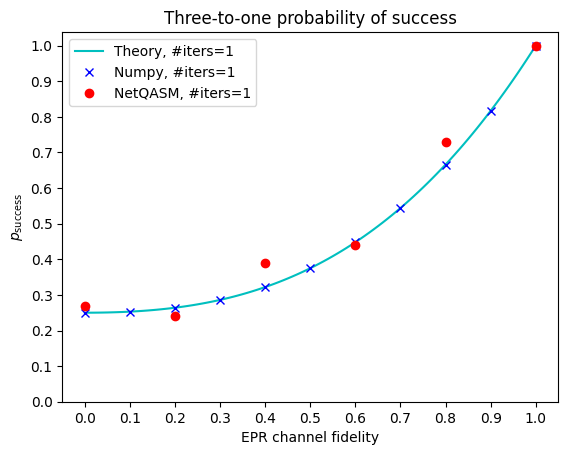

In [7]:
ps = np.linspace(0, 1, 101)
plt.plot(
    ps, prob_succ_theory(ps),
    'c-', label='Theory, #iters=1',
)
plt.plot(
    numpy_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'], 
    numpy_sim_results.query('`Gate fidelity` == 1.0')['P_Succ'],
    'xb', label='Numpy, #iters=1',
)
plt.plot(
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['P_succ'],
    'ro', label='NetQASM, #iters=1'
)
plt.title('Three-to-one probability of success')
plt.xlabel('EPR channel fidelity')
plt.ylabel(r'$p_\text{success}$')
ticks = np.arange(11)/10
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.legend()
plt.show()

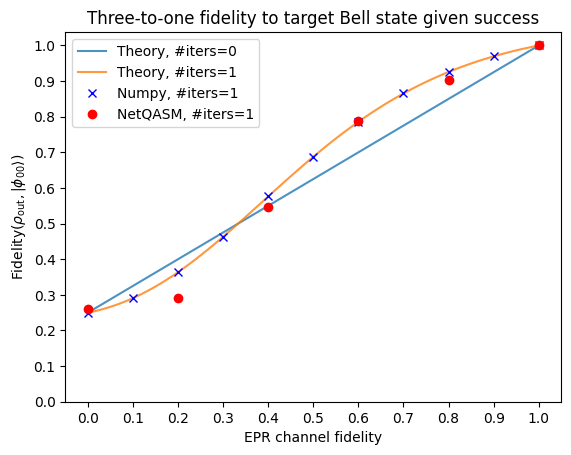

In [8]:
ps = np.linspace(0, 1, 101)

for niters in range(0, 2):
    foo = np.vectorize(lambda p: fidelity_succ_theory(p, niters))
    plt.plot(
        ps, foo(ps), 
        alpha=0.8,
        label=f'Theory, #iters={niters}',
    )

plt.plot(
    numpy_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'], 
    numpy_sim_results.query('`Gate fidelity` == 1.0')['F_succ'], 
    'xb', label='Numpy, #iters=1',
)

plt.plot(
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['EPR channel fidelity'],
    netqasm_sim_results.query('`Gate fidelity` == 1.0')['F_succ'],
    'ro', label='NetQASM, #iters=1'
)

plt.title('Three-to-one fidelity to target Bell state given success')
plt.xlabel('EPR channel fidelity')
plt.ylabel(r'$\text{Fidelity}(\rho_\text{out}, \vert\phi_{00}\rangle)$')
ticks = np.arange(11)/10
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.legend()
plt.show()